# MNIST

Training of a small MLP on MNIST with a custom loss function, for example the Minkowski loss.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
# Training settings
batch_size=64
epochs=10
lr=0.01
momentum=0.0
seed=1101

din=784
dout=10
dh=50

nbatches=30 # n.batches to evaluate statistics

In [5]:
class Net(nn.Module):
    def __init__(self,din=784, dh=30, dout=10):
        super(Net, self).__init__()
        
        self.lin1 = nn.Linear(din, dh)
        self.lin2 = nn.Linear(dh, dout)
    
    def forward(self, x):    
        x = torch.sigmoid(self.lin1(x)) 
        return self.lin2(x)

# Exercise: a new loss function

Try to use a Minkowski loss with parameter q

$$
d_q(x,y) = \left( \sum_i (x_i - y_i )^q \right)^{1/q}
$$

the only goal here is to learn how to define a new loss.
The class MinkowskiLoss receives a minibatch of data and 
returns the average Minkowski distance over a minibatch.

The way outlined is just one way, you could imagine other ways too.

In [6]:
class MinkowskiLoss(torch.nn.Module):
    def __init__(self,q):
        super(MinkowskiLoss,self).__init__()
        self.q = q
        
    def forward(self,x,y):
        loss = 0.0
        for i in range(x.shape[0]):
            loss += (torch.sum( (x[i,:]-y[i,:])**self.q) )**(1/self.q)
        return loss/x.shape[0]

**NOTE**s
- In `pytorch` every neural network model has to inherit from the `Module` container (e.g. see also the neural network definition above). This implements all the methods required to make all the framework do its job. In this case we need to **override** only the `forward` method, the `backward` one (used for backpropagation) will be inherited from the *base-class* 
- In the `__init__` function we have to call for the constructor of the base class: this is achieved by the built-in python function `super(name_of_derived_class, self).__init__()`

In [7]:
q = 6
criterion = MinkowskiLoss(q)

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    

    for batch_idx, (data, target) in enumerate(train_loader):
        
       
        data, target = data.to(device), target.to(device)
                
        data = data.view(-1,784) # *
        target = target.view(-1,1) # *
        onehot = torch.FloatTensor(data.shape[0], 10).zero_().to(device) # *
        onehot.scatter_(1, target, 1) # *
        target = onehot # *
    
        optimizer.zero_grad()
        output = model(data)    
        loss = criterion(output, target)
    
        
        loss.backward()
        optimizer.step()

In [9]:
def stats(model, device, loader, nsamples=batch_size*nbatches):
    
    model.eval() 
    
    loss = 0
    correct = 0
    count = 0
    
    origin = 'train' if loader.dataset.train else 'test'
    
    with torch.no_grad():
        
        for data, target in loader:
            
            count += data.shape[0]
                
            if count > nsamples:
                break
                
            data, target = data.to(device), target.to(device)     
            
            
            data = data.view(-1,784) # *
            target = target.view(-1,1) # *
            onehot = torch.FloatTensor(data.shape[0], 10).zero_().to(device) # *
            onehot.scatter_(1, target, 1) # *
            
    
            output = model(data)
            #print(output.shape)
            
            loss += criterion(output, onehot).item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= count  
    acc = 100. * correct / count
    

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(origin,
        loss, correct, count,
        acc ) )
    
    
    return loss,acc

In [10]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [11]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

In [12]:
model = Net(din,dh,dout).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [13]:
train_stats = []
test_stats = []

for epoch in range(1, epochs + 1):
    
    train(model, device, train_loader, optimizer, epoch)
    
    train_stats.append(stats(model, device, train_loader))
    test_stats.append(stats(model, device, test_loader))
    
train_stats = np.array(train_stats)
test_stats = np.array(test_stats)


train set: Average loss: 0.0066, Accuracy: 1555/1984 (78%)


test set: Average loss: 0.0065, Accuracy: 1604/1984 (81%)


train set: Average loss: 0.0060, Accuracy: 1645/1984 (83%)


test set: Average loss: 0.0061, Accuracy: 1622/1984 (82%)


train set: Average loss: 0.0057, Accuracy: 1658/1984 (84%)


test set: Average loss: 0.0057, Accuracy: 1666/1984 (84%)


train set: Average loss: 0.0054, Accuracy: 1665/1984 (84%)


test set: Average loss: 0.0054, Accuracy: 1688/1984 (85%)


train set: Average loss: 0.0052, Accuracy: 1679/1984 (85%)


test set: Average loss: 0.0051, Accuracy: 1714/1984 (86%)


train set: Average loss: 0.0049, Accuracy: 1717/1984 (87%)


test set: Average loss: 0.0049, Accuracy: 1732/1984 (87%)


train set: Average loss: 0.0048, Accuracy: 1720/1984 (87%)


test set: Average loss: 0.0047, Accuracy: 1730/1984 (87%)


train set: Average loss: 0.0045, Accuracy: 1725/1984 (87%)


test set: Average loss: 0.0045, Accuracy: 1734/1984 (87%)


train set: Average loss: 0.0045

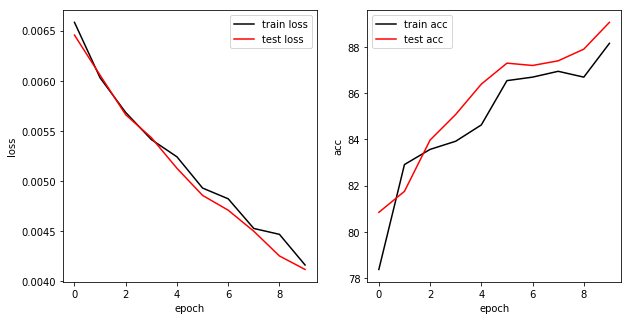

In [14]:
fig=plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_stats[:,0],'-k',label='train loss')
plt.plot(test_stats[:,0],'-r',label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.plot(train_stats[:,1],'-k',label='train acc')
plt.plot(test_stats[:,1],'-r',label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()


plt.show()